In [1]:
import os
import numpy as np
import pandas as pd
import time
from google.cloud import storage
import base64
import io
import json
import requests
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.cloud import automl
from PIL import Image
from io import BytesIO


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
def disp_confusion_matrix(test_results, label_counts, if_HE = True):
    """
    displays the confusion matrix
    args:
        test_results(pd.DataFrame) : the dataframe with the predicted labels over the test set,(ground truth column name ="gt_label")(predicted labels column name = "preds")
        label_counts(pd.DataFrame) : the dataframe with value_counts() of "gt_label" column.
    """
    display_labels = ['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']
    if if_HE == False:
        display_labels.remove('HE')

    cm = confusion_matrix(y_true=test_results['gt_label'],y_pred = test_results['preds'], labels = display_labels)
        
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    print(label_counts)
    plt.rcParams["figure.figsize"] = (10,7)
    disp = disp.plot(cmap = plt.cm.Blues)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------making predictions via cloud hosted online model-----------------------------------------------------------------#    
def predict_online(path):
    """
    args:
        path(str) : path to the image on which the model is to be tested
    returns:
        tuple(labels, scores): labels(list) : the unique multi-class labels in the dataset
                               scores(list) : the corresponding softmax probabilty value associated with each label.. 
    """
    project_id = "ihc-qc-sandbox"
    model_id = "ICN8053326738156945408"

    prediction_client = automl.PredictionServiceClient()
    buffered = BytesIO()
    im = Image.open(path)
    im.save(buffered, format="PNG")
    encoded_image = buffered.getvalue()
    image = automl.Image(image_bytes=encoded_image)
    payload = automl.ExamplePayload(image=image)
    params = {"score_threshold": "0.0"}

    request = automl.PredictRequest(
        name='projects/{}/locations/us-central1/models/{}'.format(project_id, model_id),
        payload=payload,
        params=params
    )
    response = prediction_client.predict(request=request)

    labels = []
    scores = []
    #print(response.payload)
    for result in response.payload:
        labels.append(result.display_name)
        scores.append(result.classification.score)
    prediction = labels[np.argmax(scores)]
    return (labels,scores)


def get_preds_online(df):
    '''
    get the softmax logits from the model
    args:
        df_arr : dataset in a batch of 32 samples
        df : dataset dataframe
    returns:
        df : dataset along with softmax values
    '''
    
    
    for index in tqdm(df.index):
        img_path = "/home/jupyter/" + df["path"][index][22:]
        image_key = df["path"][index]

        labels, scores = predict_online(img_path)
        #url = 'http://192.168.2.7:{}/v1/models/default:predict'.format(8501)
        #response = requests.post(url, data=json.dumps(instances))
        #res = response.json()
        for i,label in enumerate(labels):
            df.loc[df.path == image_key, label] = scores[i]
        
    
    return df


#---------------------------------------------------------------------------- end -------------------------------------------------------------------------------------------#


# ------------------------------------------------------------making predictions via edge model-----------------------------------------------------------------#    

def get_preds_edge(df_arr, df):
    for ds in tqdm(df_arr):
        instances = {
                'instances': []}
        for indx in ds.index:
            img_path = "/home/jupyter/" + df["path"][indx][22:]
            image_key = df["path"][indx]
            with io.open(img_path, 'rb') as image_file:
                encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
            example = {
                'image_bytes': {'b64': str(encoded_image)},
                'key': image_key
            }
            instances['instances'].append(example)

        url = 'http://192.168.2.7:{}/v1/models/default:predict'.format(8501)
        response = requests.post(url, data=json.dumps(instances))
        res = response.json()
        for pred in res["predictions"]:
            key = pred['key']
            for i,label in enumerate(pred['labels']):
                ds.loc[df.path == key, label] = pred['scores'][i]

    df = pd.concat(df_arr)
    return df

#---------------------------------------------------------------------------- end -------------------------------------------------------------------------------------------#



# --------------------------------------------------returns accuracy count based on thresholds set for each class -----------------------------------------------------#
def out_of_focus(out_of_focus_prob, thresh):
    if out_of_focus_prob > thresh:
        return True
    else:
        return False
    
def strong_positive(strong_positive_prob, thresh):
    if strong_positive_prob > thresh:
        return True
    else:
        return False
    
def negative(negative_prob, thresh):
    if negative_prob > thresh:
        return True
    else:
        return False
    
def dim_positive(dim_positive_prob, thresh):
    if dim_positive_prob > thresh:
        return True
    else:
        return False
    
def no_tissue(no_tissue_prob, thresh):
    if no_tissue_prob > thresh:
        return True
    else:
        return False
    
def necrotic(necrotic_prob, thresh):
    if necrotic_prob > thresh:
        return True
    else:
        return False
    
def he(he_prob, thresh):
    if he_prob > thresh:
        return True
    else:
        return False

def get_acc_count(df, thresh):
    
    acc_count = {"out_of_focus": {"tp": 0, "fp": 0, "total": 0},
                 "strong_positive": {"tp": 0, "fp": 0, "total": 0},
                 "negative": {"tp": 0, "fp":0, "total": 0},
                 "dim_positive": {"tp": 0, "fp":0, "total": 0},
                 "no_tissue": {"tp": 0, "fp":0, "total": 0},
                 "necrotic": {"tp": 0, "fp":0, "total": 0},
                 "HE": {"tp": 0, "fp":0, "total": 0}}
    df = test_results

    if 'preds' in df.columns:
        df.drop(columns=['preds'], inplace =True)
    df["preds"] = ""
    for indx in df.index:
        gt_label = df["gt_label"][indx]
        #if gt_label == "necrotic" or gt_label == "HE" or gt_label == "no_tissue" or gt_label == "dim_positive":
            #continue
        acc_count[gt_label]["total"] += 1
        out_of_focus_prob, strong_positive_prob, negative_prob, dim_positive_prob, no_tissue_prob, necrotic_prob, he_prob = df["out_of_focus"][indx], df["strong_positive"][indx], df["negative"][indx], df["dim_positive"][indx], df["no_tissue"][indx], df["necrotic"][indx], df["HE"][indx]
        # OOF
        if out_of_focus(out_of_focus_prob,thresh):
            if gt_label == "out_of_focus":
                acc_count[gt_label]["tp"] += 1
            else:
                #print(df["path"][indx])
                acc_count["out_of_focus"]["fp"] += 1
            df["preds"][indx] = "out_of_focus"
            continue

        # Strong Positive
        if strong_positive(strong_positive_prob,thresh):
            if gt_label == "strong_positive":
                acc_count[gt_label]["tp"] += 1
            else:
                acc_count["strong_positive"]["fp"] += 1
                #print(df["gt_label"][indx], brown_cover)
            df["preds"][indx] = "strong_positive"
            continue

        # Negative
        if negative(negative_prob, thresh):
            if gt_label == "negative":
                acc_count[gt_label]["tp"] += 1
            else:
                acc_count["negative"]["fp"] += 1
            df["preds"][indx] = "negative"
            continue

        # dim_positive
        if dim_positive(dim_positive_prob,thresh):
            if gt_label == "dim_positive":
                acc_count[gt_label]["tp"] += 1
            else:
                acc_count["dim_positive"]["fp"] += 1
            df["preds"][indx] = "dim_positive"
            continue


        # necrotic
        if necrotic(necrotic_prob,thresh):
            if gt_label == "necrotic":
                acc_count[gt_label]["tp"] += 1
            else:
                acc_count["necrotic"]["fp"] += 1
            df["preds"][indx] = "necrotic"
            continue

        # HE
        if he(he_prob, thresh):
            if gt_label == "HE":
                acc_count[gt_label]["tp"] += 1
            else:
                acc_count["HE"]["fp"] += 1
            df["preds"][indx] = "HE"
            continue

        if no_tissue(no_tissue_prob, thresh):
            if gt_label == "no_tissue":
                acc_count[gt_label]["tp"] += 1
            else:
                acc_count["no_tissue"]["fp"] += 1
            df["preds"][indx] = "no_tissue"
            continue
    return acc_count

#---------------------------------------------------------------------------- end -------------------------------------------------------------------------------------------#



#-------------------------------------------------------returns accuracy count based on softmax values(argmax)---------------------------------------------------------------#
def get_acc_count_max(df, if_HE = True):
    '''
    calculate a dictionary of metrics like TP, FP and total examples for each label
    args:
        df : dataset 
    '''
    
    acc_count = {"out_of_focus": {"tp": 0, "fp": 0, "total": 0},
                 "strong_positive": {"tp": 0, "fp": 0, "total": 0},
                 "negative": {"tp": 0, "fp":0, "total": 0},
                 "dim_positive": {"tp": 0, "fp":0, "total": 0},
                 "no_tissue": {"tp": 0, "fp":0, "total": 0},
                 "necrotic": {"tp": 0, "fp":0, "total": 0},
                 "HE": {"tp": 0, "fp":0, "total": 0}}
    df = test_results
    for indx in df.index:
        gt_label = df["gt_label"][indx]
        pred_label = df["preds"][indx]
        #if gt_label == "necrotic" or gt_label == "HE" or gt_label == "no_tissue" or gt_label == "dim_positive":
            #continue
        acc_count[gt_label]["total"] += 1
        out_of_focus_prob, strong_positive_prob, negative_prob, dim_positive_prob, no_tissue_prob, necrotic_prob, he_prob = df["out_of_focus"][indx], df["strong_positive"][indx], df["negative"][indx], df["dim_positive"][indx], df["no_tissue"][indx], df["necrotic"][indx], df["HE"][indx]
        if gt_label == 'out_of_focus':
            if pred_label == 'out_of_focus':
                acc_count[gt_label]["tp"] += 1
            else:
                #print(df["path"][indx])
                acc_count["out_of_focus"]["fp"] += 1
                continue
        elif gt_label == 'strong_positive':
            if pred_label == 'strong_positive':
                acc_count[gt_label]["tp"] += 1
            else:
                #print(df["path"][indx])
                acc_count["strong_positive"]["fp"] += 1
                continue
        elif gt_label == 'dim_positive':
            if pred_label == 'dim_positive':
                acc_count[gt_label]["tp"] += 1
            else:
                #print(df["path"][indx])
                acc_count["dim_positive"]["fp"] += 1
                continue
        elif gt_label == 'negative':
            if pred_label == 'negative':
                acc_count[gt_label]["tp"] += 1
            else:
                #print(df["path"][indx])
                acc_count["negative"]["fp"] += 1
                continue
        elif gt_label == 'no_tissue':
            if pred_label == 'no_tissue':
                acc_count[gt_label]["tp"] += 1
            else:
                #print(df["path"][indx])
                acc_count["no_tissue"]["fp"] += 1
                continue

        elif gt_label == 'HE' and if_HE == HE:
            if pred_label == 'HE':
                acc_count[gt_label]["tp"] += 1
            else:
                #print(df["path"][indx])
                acc_count["HE"]["fp"] += 1
                continue
        elif gt_label == 'necrotic':
            if pred_label == 'necrotic':
                acc_count[gt_label]["tp"] += 1
            else:
                #print(df["path"][indx])
                acc_count["necrotic"]["fp"] += 1
                continue
    if if_HE == False:
        acc_count.pop('HE')
    return acc_count
        


        


                
    

## without HE, cloud hosted model 

In [35]:
#csv file path to tiles data in subset
'''
step 1: export the dataset to gcs 
step 2: copy that folder structure in local
step 3: read the csv files which has split, path and ground truth.(dataset might be divided into multiple csv files)
step 4: concat the read csv files to one dataframe
'''
csv_path1 = "/home/jupyter/subset_all_combined/export_data-without_HE-2021-01-19T06:28:39.516859Z/image_classification_1.csv"
df1 = pd.read_csv(csv_path1, header=None)
csv_path2 = "/home/jupyter/subset_all_combined/export_data-without_HE-2021-01-19T06:28:39.516859Z/image_classification_2.csv"
df2 = pd.read_csv(csv_path2, header=None)

df = pd.concat([df1, df2], ignore_index=True)
print(df[2].value_counts())
df.rename(columns={0:"split", 1:"path", 2:"gt_label"}, inplace=True)
df['strong_positive'] = 0.0 
df['negative']= 0.0
df['dim_positive'] = 0.0
df['no_tissue'] = 0.0
df['out_of_focus'] = 0.0
df['necrotic'] = 0.0
df['HE'] = 0.0
df

out_of_focus       5228
no_tissue          4660
negative           3228
strong_positive    3115
dim_positive       1672
necrotic            696
Name: 2, dtype: int64


,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
18594,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18595,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18596,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18597,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
test_results=df[df['split']=='TEST']

In [37]:
df = test_results

In [38]:
df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
40,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
18571,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18580,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18584,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18591,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
BATCH_SIZE = 32
df_test = df[df["split"] == 'TEST']
equal_parts = int(df_test.shape[0]/BATCH_SIZE) + 1
df_arr = np.array_split(df, equal_parts)
len(df_arr)

58

In [40]:
df_arr[0].shape

(32, 10)

In [12]:
import os
os.path.exists('/home/jupyter/subset_1_1/export_data-seagen_subset_1_1-2020-12-23T08:55:47.943745Z/files/12574b2e-5a89-4a2d-a2e7-deec0a12707a.png')

False

In [41]:
df = get_preds_online(df)

  0%|          | 0/1846 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
100%|██████████| 1846/1846 [28:09<00:00,  1.09it/s]


In [42]:
# uncomment the below line to save the predictions csv
#df.to_csv("/home/jupyter/model_preds/preds/online_without_HE.csv", index=False)

In [39]:
df = pd.read_csv("/home/jupyter/model_preds/preds/online_without_HE.csv")
df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,1.384687e-10,2.630884e-06,2.633813e-08,9.999841e-01,1.319978e-05,5.182396e-10,0.0
1,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,4.907777e-11,3.041271e-06,6.088877e-08,9.999950e-01,1.840505e-06,5.135585e-10,0.0
2,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,2.031016e-05,5.331222e-01,4.668319e-01,1.686948e-05,3.238064e-07,8.328410e-06,0.0
3,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,7.813460e-21,2.634760e-15,5.481385e-17,5.372924e-10,1.000000e+00,5.615472e-21,0.0
4,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,1.391402e-09,3.612532e-07,1.469486e-08,9.998876e-01,1.120898e-04,2.411575e-10,0.0
...,...,...,...,...,...,...,...,...,...,...
1841,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,4.972770e-15,6.700640e-14,2.843754e-13,8.915841e-08,9.999999e-01,2.861189e-18,0.0
1842,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,9.999971e-01,3.590634e-15,2.611701e-06,1.494607e-09,3.213690e-09,2.163749e-07,0.0
1843,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,9.999967e-01,4.504796e-15,3.258479e-06,3.197569e-10,1.204039e-10,8.552954e-08,0.0
1844,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,1.842860e-06,8.165540e-01,1.824847e-01,9.002898e-04,1.925598e-07,5.910053e-05,0.0


In [40]:
test_results = df

In [41]:
test_results['preds'] = test_results[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']].idxmax(axis=1)

In [69]:
test_results[df['gt_label'] == 'dim_positive']

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
16,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,3.291885e-01,0.009023,0.653827,9.466619e-05,6.574951e-04,0.007210,0.0,dim_positive
26,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,5.477585e-02,0.009580,0.935634,2.448122e-06,2.052438e-07,0.000007,0.0,dim_positive
33,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,2.954820e-02,0.000196,0.958370,1.495565e-05,3.982376e-06,0.011867,0.0,dim_positive
40,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,1.633177e-03,0.001099,0.997266,2.187826e-08,3.706542e-08,0.000002,0.0,dim_positive
45,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,6.256784e-01,0.000094,0.371912,2.419876e-06,7.156229e-06,0.002306,0.0,strong_positive
...,...,...,...,...,...,...,...,...,...,...,...
1782,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,3.456909e-03,0.095164,0.898410,1.426816e-03,8.726466e-05,0.001456,0.0,dim_positive
1808,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,7.605381e-02,0.019528,0.231241,1.508237e-01,1.381870e-03,0.520971,0.0,necrotic
1820,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,2.918174e-01,0.000577,0.684024,5.870648e-05,2.186406e-05,0.023501,0.0,dim_positive
1822,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,1.537926e-03,0.020556,0.501635,2.588244e-02,2.450450e-04,0.450144,0.0,dim_positive


In [43]:
label_counts = test_results['gt_label'].value_counts()
label_counts = pd.DataFrame(data=label_counts).rename(columns={"gt_label":"gt_label_count"})

In [44]:
label_counts

,gt_label_count
out_of_focus,503
no_tissue,464
negative,330
strong_positive,321
dim_positive,159
necrotic,69


In [45]:
test_results['preds'].value_counts()

out_of_focus       498
no_tissue          463
negative           357
strong_positive    334
dim_positive       136
necrotic            58
Name: preds, dtype: int64

In [46]:
print(classification_report(test_results[['gt_label']], test_results[['preds']]))


                 precision    recall  f1-score   support

   dim_positive       0.89      0.76      0.82       159
       necrotic       0.72      0.61      0.66        69
       negative       0.90      0.98      0.94       330
      no_tissue       0.97      0.97      0.97       464
   out_of_focus       0.99      0.98      0.98       503
strong_positive       0.92      0.95      0.93       321

       accuracy                           0.94      1846
      macro avg       0.90      0.87      0.88      1846
   weighted avg       0.94      0.94      0.94      1846



                 gt_label_count
out_of_focus                503
no_tissue                   464
negative                    330
strong_positive             321
dim_positive                159
necrotic                     69


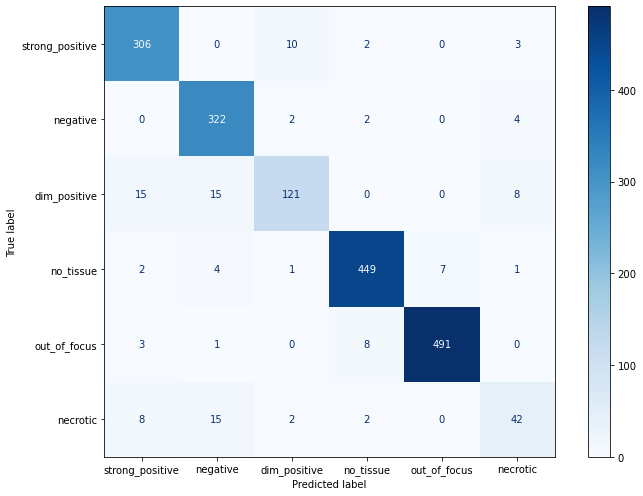

In [47]:
disp_confusion_matrix(test_results, label_counts, if_HE = False)

In [48]:
misclassified_df = test_results[test_results['gt_label'] != test_results['preds']]
misclassified_df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
15,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,1.790771e-05,0.000880,0.000145,0.716227,2.827262e-01,3.659665e-06,0.0,no_tissue
45,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,6.256784e-01,0.000094,0.371912,0.000002,7.156229e-06,2.306352e-03,0.0,strong_positive
46,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,4.700625e-07,0.858485,0.140637,0.000074,1.333137e-07,8.031036e-04,0.0,negative
52,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,5.374395e-04,0.485592,0.506129,0.005157,2.061384e-05,2.564789e-03,0.0,dim_positive
64,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,4.906571e-01,0.001244,0.491163,0.000214,2.321566e-03,1.440089e-02,0.0,dim_positive
...,...,...,...,...,...,...,...,...,...,...,...
1783,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,2.662849e-01,0.011148,0.719555,0.000325,1.156864e-03,1.530137e-03,0.0,dim_positive
1791,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,2.287647e-07,0.000007,0.000006,0.178065,8.219216e-01,8.127785e-08,0.0,out_of_focus
1800,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,1.485152e-05,0.410266,0.044773,0.001917,4.212797e-06,5.430244e-01,0.0,necrotic
1808,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,7.605381e-02,0.019528,0.231241,0.150824,1.381870e-03,5.209714e-01,0.0,necrotic


In [50]:
#misclassified_df[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']].apply(lambda x:list(misclassified_df.columns[np.array(x).argsort()[::-1][:3]]), axis=1).to_list()
data = misclassified_df[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']]
tops =pd.DataFrame(misclassified_df[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']].apply(lambda x:list(misclassified_df.columns[3:10][np.array(x).argsort()[::-1][:3]]), axis=1).to_list(),  columns=['Top1', 'Top2', 'Top3'])
misclassified_df = misclassified_df.reset_index(drop=True)
tops = tops.reset_index(drop=True)
new_df = misclassified_df.join(tops)


In [73]:
new_df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds,Top1,Top2,Top3
0,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,1.790771e-05,0.000880,0.000145,0.716227,2.827262e-01,3.659665e-06,0.0,no_tissue,no_tissue,out_of_focus,negative
1,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,6.256784e-01,0.000094,0.371912,0.000002,7.156229e-06,2.306352e-03,0.0,strong_positive,strong_positive,dim_positive,necrotic
2,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,4.700625e-07,0.858485,0.140637,0.000074,1.333137e-07,8.031036e-04,0.0,negative,negative,dim_positive,necrotic
3,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,5.374395e-04,0.485592,0.506129,0.005157,2.061384e-05,2.564789e-03,0.0,dim_positive,dim_positive,negative,no_tissue
4,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,4.906571e-01,0.001244,0.491163,0.000214,2.321566e-03,1.440089e-02,0.0,dim_positive,dim_positive,strong_positive,necrotic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,2.662849e-01,0.011148,0.719555,0.000325,1.156864e-03,1.530137e-03,0.0,dim_positive,dim_positive,strong_positive,negative
111,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,2.287647e-07,0.000007,0.000006,0.178065,8.219216e-01,8.127785e-08,0.0,out_of_focus,out_of_focus,no_tissue,negative
112,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,1.485152e-05,0.410266,0.044773,0.001917,4.212797e-06,5.430244e-01,0.0,necrotic,necrotic,negative,dim_positive
113,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,7.605381e-02,0.019528,0.231241,0.150824,1.381870e-03,5.209714e-01,0.0,necrotic,necrotic,dim_positive,no_tissue


In [52]:
misclassified_df['gt_label'].value_counts()

dim_positive       38
necrotic           27
strong_positive    15
no_tissue          15
out_of_focus       12
negative            8
Name: gt_label, dtype: int64

In [74]:
misclassified_df[(misclassified_df['gt_label'] == 'dim_positive') & (misclassified_df['strong_positive'] > 0.5)]

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
1,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.625678,9.382366e-05,0.371912,2.419876e-06,7.156229e-06,0.002306,0.0,strong_positive
26,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.725171,4.035529e-07,0.274819,1.460226e-09,2.726305e-08,0.000009,0.0,strong_positive
31,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.919962,3.477357e-05,0.033384,2.542962e-02,4.885208e-04,0.020702,0.0,strong_positive
45,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.513743,4.505724e-06,0.486246,3.542397e-09,8.218920e-08,0.000006,0.0,strong_positive
50,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.664683,5.181928e-05,0.322040,6.985942e-06,2.147963e-05,0.013196,0.0,strong_positive
56,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.577772,4.568867e-04,0.421673,2.021593e-06,1.679083e-05,0.000079,0.0,strong_positive
68,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.577718,3.419451e-05,0.422004,1.561724e-07,7.537660e-07,0.000242,0.0,strong_positive
71,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.881107,7.427911e-08,0.118880,2.945620e-09,2.755819e-09,0.000012,0.0,strong_positive
83,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.615777,4.980051e-03,0.343384,4.001530e-03,2.824689e-04,0.031575,0.0,strong_positive
89,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.710987,5.456344e-05,0.278862,2.255162e-05,8.542575e-06,0.010066,0.0,strong_positive


In [70]:
import shutil
row = 26
shutil.copy("/home/jupyter/" + test_results["path"][row][22:], "/home/jupyter/test.png")

'/home/jupyter/test.png'

## Calculating accuarcy metrics 

In [23]:
softmax_acc_count = get_acc_count_max(test_results, if_HE = False)

In [24]:
softmax_acc_count 

{'out_of_focus': {'tp': 491, 'fp': 12, 'total': 503},
 'strong_positive': {'tp': 306, 'fp': 15, 'total': 321},
 'negative': {'tp': 322, 'fp': 8, 'total': 330},
 'dim_positive': {'tp': 121, 'fp': 38, 'total': 159},
 'no_tissue': {'tp': 449, 'fp': 15, 'total': 464},
 'necrotic': {'tp': 42, 'fp': 27, 'total': 69}}

In [25]:
for key in softmax_acc_count:
    print("'{}'".format(key))
    acc = softmax_acc_count[key]["tp"]*100/softmax_acc_count[key]["total"]
    precision = softmax_acc_count[key]["tp"]*100/(softmax_acc_count[key]["tp"] + softmax_acc_count[key]["fp"])
    print("Total samples: {}".format(softmax_acc_count[key]["total"]))
    print("True positives: {}".format(softmax_acc_count[key]["tp"]))
    print("False positives: {}".format(softmax_acc_count[key]["fp"]))
    print("Accuracy for '{}' is {}".format(key, acc))
    #print("Precision for '{}' is {}".format(key, precision))

    print()

'out_of_focus'
Total samples: 503
True positives: 491
False positives: 12
Accuracy for 'out_of_focus' is 97.61431411530815

'strong_positive'
Total samples: 321
True positives: 306
False positives: 15
Accuracy for 'strong_positive' is 95.32710280373831

'negative'
Total samples: 330
True positives: 322
False positives: 8
Accuracy for 'negative' is 97.57575757575758

'dim_positive'
Total samples: 159
True positives: 121
False positives: 38
Accuracy for 'dim_positive' is 76.1006289308176

'no_tissue'
Total samples: 464
True positives: 449
False positives: 15
Accuracy for 'no_tissue' is 96.76724137931035

'necrotic'
Total samples: 69
True positives: 42
False positives: 27
Accuracy for 'necrotic' is 60.869565217391305



## without HE, Edge model Evaluation

In [18]:
#df = get_preds_edge(df_arr, df)

100%|██████████| 58/58 [03:23<00:00,  3.51s/it]


In [19]:
#df.to_csv("/home/jupyter/model_preds/preds/edge_without_HE.csv", index=False)

In [26]:
df = pd.read_csv("/home/jupyter/model_preds/preds/edge_without_HE.csv")
df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.015880,0.015880,0.016350,0.920761,0.018921,0.012209,0.0
1,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.014439,0.015308,0.016229,0.813142,0.129113,0.011769,0.0
2,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,0.021703,0.788620,0.121614,0.018754,0.028229,0.021079,0.0
3,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.029372,0.038203,0.032062,0.029372,0.844858,0.026133,0.0
4,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.019813,0.016149,0.018151,0.909446,0.019813,0.016628,0.0
...,...,...,...,...,...,...,...,...,...,...
1841,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.019883,0.018755,0.025861,0.021704,0.886380,0.027417,0.0
1842,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,0.801307,0.031310,0.044455,0.049964,0.040725,0.032238,0.0
1843,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,0.909336,0.015231,0.022926,0.017119,0.016147,0.019240,0.0
1844,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,0.011701,0.832396,0.048957,0.043559,0.025747,0.037640,0.0


In [27]:
test_results = df

In [28]:
test_results['preds'] = test_results[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']].idxmax(axis=1)

In [29]:
test_results

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
0,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.015880,0.015880,0.016350,0.920761,0.018921,0.012209,0.0,no_tissue
1,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.014439,0.015308,0.016229,0.813142,0.129113,0.011769,0.0,no_tissue
2,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,0.021703,0.788620,0.121614,0.018754,0.028229,0.021079,0.0,negative
3,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.029372,0.038203,0.032062,0.029372,0.844858,0.026133,0.0,out_of_focus
4,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.019813,0.016149,0.018151,0.909446,0.019813,0.016628,0.0,no_tissue
...,...,...,...,...,...,...,...,...,...,...,...
1841,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.019883,0.018755,0.025861,0.021704,0.886380,0.027417,0.0,out_of_focus
1842,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,0.801307,0.031310,0.044455,0.049964,0.040725,0.032238,0.0,strong_positive
1843,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,0.909336,0.015231,0.022926,0.017119,0.016147,0.019240,0.0,strong_positive
1844,TEST,gs://seagen-quantiphi/subset_all_combined/expo...,negative,0.011701,0.832396,0.048957,0.043559,0.025747,0.037640,0.0,negative


In [30]:
label_counts = test_results['gt_label'].value_counts()
label_counts = pd.DataFrame(data=label_counts).rename(columns={"gt_label":"gt_label_count"})

In [31]:
label_counts

,gt_label_count
out_of_focus,503
no_tissue,464
negative,330
strong_positive,321
dim_positive,159
necrotic,69


In [32]:
test_results['preds'].value_counts()

out_of_focus       501
no_tissue          480
strong_positive    325
negative           315
dim_positive       159
necrotic            66
Name: preds, dtype: int64

In [33]:
print(classification_report(test_results[['gt_label']], test_results[['preds']]))


                 precision    recall  f1-score   support

   dim_positive       0.78      0.78      0.78       159
       necrotic       0.61      0.58      0.59        69
       negative       0.94      0.90      0.92       330
      no_tissue       0.94      0.98      0.96       464
   out_of_focus       0.98      0.98      0.98       503
strong_positive       0.93      0.94      0.94       321

       accuracy                           0.93      1846
      macro avg       0.86      0.86      0.86      1846
   weighted avg       0.93      0.93      0.93      1846



                 gt_label_count
out_of_focus                503
no_tissue                   464
negative                    330
strong_positive             321
dim_positive                159
necrotic                     69


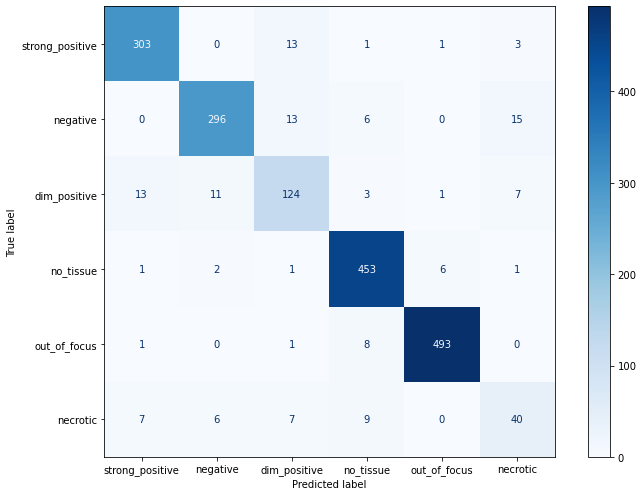

In [35]:
disp_confusion_matrix(test_results, label_counts, if_HE = False)

## Calculating accuarcy metrics 

In [36]:
softmax_acc_count = get_acc_count_max(test_results, if_HE= False)

In [37]:
softmax_acc_count 

{'out_of_focus': {'tp': 493, 'fp': 10, 'total': 503},
 'strong_positive': {'tp': 303, 'fp': 18, 'total': 321},
 'negative': {'tp': 296, 'fp': 34, 'total': 330},
 'dim_positive': {'tp': 124, 'fp': 35, 'total': 159},
 'no_tissue': {'tp': 453, 'fp': 11, 'total': 464},
 'necrotic': {'tp': 40, 'fp': 29, 'total': 69}}

In [38]:
for key in softmax_acc_count:
    print("'{}'".format(key))
    acc = softmax_acc_count[key]["tp"]*100/softmax_acc_count[key]["total"]
    precision = softmax_acc_count[key]["tp"]*100/(softmax_acc_count[key]["tp"] + softmax_acc_count[key]["fp"])
    print("Total samples: {}".format(softmax_acc_count[key]["total"]))
    print("True positives: {}".format(softmax_acc_count[key]["tp"]))
    print("False positives: {}".format(softmax_acc_count[key]["fp"]))
    print("Accuracy for '{}' is {}".format(key, acc))
    #print("Precision for '{}' is {}".format(key, precision))

    print()

'out_of_focus'
Total samples: 503
True positives: 493
False positives: 10
Accuracy for 'out_of_focus' is 98.01192842942346

'strong_positive'
Total samples: 321
True positives: 303
False positives: 18
Accuracy for 'strong_positive' is 94.39252336448598

'negative'
Total samples: 330
True positives: 296
False positives: 34
Accuracy for 'negative' is 89.6969696969697

'dim_positive'
Total samples: 159
True positives: 124
False positives: 35
Accuracy for 'dim_positive' is 77.9874213836478

'no_tissue'
Total samples: 464
True positives: 453
False positives: 11
Accuracy for 'no_tissue' is 97.62931034482759

'necrotic'
Total samples: 69
True positives: 40
False positives: 29
Accuracy for 'necrotic' is 57.971014492753625



# for model trained on subsets 1_1, 1_2, 1_3 and 1_4 combined
## Tested on test set

In [16]:
#csv file path to tiles data in subset
'''
step 1: export the dataset to gcs 
step 2: copy that folder structure in local
step 3: read the csv files which has split, path and ground truth.(dataset might be divided into multiple csv files)
step 4: concat the read csv files to one dataframe
'''
csv_path1 = "/home/jupyter/image_classification_1.csv"
df1 = pd.read_csv(csv_path1, header=None)
csv_path2 = "/home/jupyter/image_classification_2.csv"
df2 = pd.read_csv(csv_path2, header=None)
csv_path3 = "/home/jupyter/image_classification_3.csv"
df3 = pd.read_csv(csv_path3, header=None)

df = pd.concat([df1, df2, df3], ignore_index=True)
print(df[2].value_counts())
df.rename(columns={0:"split", 1:"path", 2:"gt_label"}, inplace=True)
df['strong_positive'] = 0.0 
df['negative']= 0.0
df['dim_positive'] = 0.0
df['no_tissue'] = 0.0
df['out_of_focus'] = 0.0
df['necrotic'] = 0.0
df['HE'] = 0.0
df

out_of_focus       4846
no_tissue          4170
negative           3228
strong_positive    3115
he                 2812
dim_positive       1672
exclusion           696
Name: 2, dtype: int64


,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,dim_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
20534,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,he,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20535,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,strong_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20536,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20537,TRAIN,gs://seagen-quantiphi/subset_all_combined/expo...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
test_results=df[df['split']=='TEST']

In [125]:
df = test_results

In [126]:
df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
50,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,HE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
22242,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,HE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22246,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,strong_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22255,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22257,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
'''
dividing data into batch of 32 samples
'''
BATCH_SIZE = 32
df_test = df[df["split"] == 'TEST']
equal_parts = int(df_test.shape[0]/BATCH_SIZE) + 1
df_arr = np.array_split(df, equal_parts)
len(df_arr)

70

In [128]:
df_arr = df_arr[0:2]

In [ ]:
img_pat
img_path.append("/home/jupyter/" + df["path"][50][22:])
img_path.append("/home/jupyter/" + df["path"][70][22:])

predict_online(img_path)

In [131]:
df = get_preds(df)

  0%|          | 0/2228 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
100%|██████████| 2228/2228 [34:16<00:00,  1.08it/s]


In [132]:
# to save the softmax values to a csv
df.to_csv("/home/jupyter/model_preds/preds/cloud_v1_1234_preds.csv", index=False)

In [3]:
df = pd.read_csv("/home/jupyter/model_preds/preds/cloud_v1_1234_preds.csv")
df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,6.967142e-11,4.035468e-06,2.190293e-08,9.999456e-01,5.032906e-05,1.249606e-08,5.895533e-09
1,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,1.130581e-11,3.388452e-06,1.323563e-08,9.999496e-01,4.702338e-05,7.605879e-09,3.011736e-09
2,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,negative,8.479918e-05,6.602845e-01,3.391708e-01,3.274760e-05,1.880178e-05,4.061942e-04,2.080289e-06
3,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,1.867014e-15,1.443656e-11,1.172422e-10,2.005917e-06,9.999241e-01,7.686700e-12,7.388498e-05
4,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,HE,3.624730e-06,3.945577e-07,6.281730e-06,1.211256e-03,1.620041e-01,6.259558e-07,8.367737e-01
...,...,...,...,...,...,...,...,...,...,...
2223,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,HE,5.512828e-05,3.901086e-08,9.358335e-06,6.606416e-05,2.296849e-01,7.488827e-07,7.701838e-01
2224,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,strong_positive,9.999715e-01,7.088027e-14,2.834479e-05,3.046781e-09,2.524282e-08,5.976721e-08,1.400845e-13
2225,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,negative,8.425493e-06,8.736010e-01,1.257693e-01,1.872150e-04,2.774720e-06,4.256332e-04,5.653491e-06
2226,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,2.094694e-06,1.110674e-05,2.344353e-07,9.996589e-01,7.376697e-05,6.576192e-07,2.532324e-04


In [4]:
test_results = df

In [5]:
test_results['preds'] = test_results[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']].idxmax(axis=1)

In [18]:
classified_df = test_results[test_results['gt_label'] == test_results['preds']]
classified_df.head(1)

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
0,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,6.967142e-11,0.000004,2.190293e-08,0.999946,0.00005,1.249606e-08,5.895533e-09,no_tissue


In [48]:
classified_df[classified_df['preds']=='out_of_focus']

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
3,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,1.867014e-15,1.443656e-11,1.172422e-10,2.005917e-06,0.999924,7.686700e-12,7.388498e-05,out_of_focus
23,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,6.299681e-24,7.502313e-18,4.996648e-17,8.912849e-08,1.000000,9.033357e-22,2.272817e-11,out_of_focus
25,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,7.861206e-11,5.142969e-07,2.532523e-06,3.871162e-04,0.999610,6.599338e-11,1.145448e-07,out_of_focus
30,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,4.438874e-25,8.370428e-17,1.266782e-17,2.866990e-07,1.000000,1.873035e-21,4.401538e-12,out_of_focus
33,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,4.380668e-11,4.327602e-07,2.891071e-06,1.042070e-04,0.730851,9.825675e-09,2.690413e-01,out_of_focus
...,...,...,...,...,...,...,...,...,...,...,...
2187,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,5.214977e-15,6.342699e-16,1.098909e-12,3.011642e-07,1.000000,2.710513e-16,3.141008e-12,out_of_focus
2191,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,2.222866e-07,2.075071e-07,6.352549e-06,1.603725e-03,0.607817,4.976531e-07,3.905722e-01,out_of_focus
2211,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,1.760487e-09,2.551943e-11,2.825263e-09,4.505371e-04,0.999549,3.700165e-12,4.378525e-09,out_of_focus
2213,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,3.313129e-15,9.764571e-08,5.635751e-10,1.389123e-04,0.999861,3.779045e-12,2.005219e-07,out_of_focus


In [33]:
classified_df.loc[2223]

split                                                           TEST
path               gs://seagen-quantiphi/export_data-all_subsets_...
gt_label                                                          HE
strong_positive                                             0.000055
negative                                                    0.000000
dim_positive                                                0.000009
no_tissue                                                   0.000066
out_of_focus                                                0.229685
necrotic                                                    0.000001
HE                                                          0.770184
preds                                                             HE
Name: 2223, dtype: object

In [32]:
classified_df.loc[2224]

split                                                           TEST
path               gs://seagen-quantiphi/export_data-all_subsets_...
gt_label                                             strong_positive
strong_positive                                             0.999972
negative                                                    0.000000
dim_positive                                                0.000028
no_tissue                                                   0.000000
out_of_focus                                                0.000000
necrotic                                                    0.000000
HE                                                          0.000000
preds                                                strong_positive
Name: 2224, dtype: object

In [34]:
classified_df.loc[2]

split                                                           TEST
path               gs://seagen-quantiphi/export_data-all_subsets_...
gt_label                                                    negative
strong_positive                                             0.000085
negative                                                    0.660284
dim_positive                                                0.339171
no_tissue                                                   0.000033
out_of_focus                                                0.000019
necrotic                                                    0.000406
HE                                                          0.000002
preds                                                       negative
Name: 2, dtype: object

In [42]:
classified_df.loc[2]

split                                                           TEST
path               gs://seagen-quantiphi/export_data-all_subsets_...
gt_label                                                    negative
strong_positive                                             0.000085
negative                                                    0.660284
dim_positive                                                0.339171
no_tissue                                                   0.000033
out_of_focus                                                0.000019
necrotic                                                    0.000406
HE                                                          0.000002
preds                                                       negative
Name: 2, dtype: object

In [51]:
classified_df.loc[2211]

split                                                           TEST
path               gs://seagen-quantiphi/export_data-all_subsets_...
gt_label                                                out_of_focus
strong_positive                                             0.000000
negative                                                    0.000000
dim_positive                                                0.000000
no_tissue                                                   0.000451
out_of_focus                                                0.999549
necrotic                                                    0.000000
HE                                                          0.000000
preds                                                   out_of_focus
Name: 2211, dtype: object

In [47]:
classified_df.loc[1201]

split                                                           TEST
path               gs://seagen-quantiphi/export_data-all_subsets_...
gt_label                                                    necrotic
strong_positive                                             0.001608
negative                                                    0.076758
dim_positive                                                0.089823
no_tissue                                                   0.053951
out_of_focus                                                0.006019
necrotic                                                    0.767569
HE                                                          0.004273
preds                                                       necrotic
Name: 1201, dtype: object

In [50]:
import shutil
row = 2211
shutil.copy("/home/jupyter/" + classified_df["path"][row][22:], "/home/jupyter/oof.png")

'/home/jupyter/oof.png'

In [7]:
label_counts = test_results['gt_label'].value_counts()
label_counts = pd.DataFrame(data=label_counts).rename(columns={"gt_label":"gt_label_count"})

## getting misclassified tiles

In [8]:
misclassified_df = test_results[test_results['gt_label'] != test_results['preds']]
misclassified_df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
6,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,2.735224e-08,4.728802e-08,9.371529e-07,0.000170,0.067769,7.666844e-07,9.320593e-01,HE
17,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,6.606802e-04,8.932314e-03,1.936961e-03,0.323371,0.221297,1.972378e-03,4.418290e-01,HE
31,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,1.795059e-07,1.458065e-06,1.097016e-05,0.000217,0.286660,9.717627e-07,7.131102e-01,HE
50,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,dim_positive,6.463339e-01,2.106629e-04,3.430184e-01,0.000091,0.000008,1.033775e-02,1.449881e-08,strong_positive
51,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,dim_positive,7.737202e-07,9.170010e-01,8.160784e-02,0.000018,0.000009,1.358670e-03,4.044883e-06,negative
...,...,...,...,...,...,...,...,...,...,...,...
2173,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,negative,3.332973e-05,4.635312e-01,4.223683e-02,0.001561,0.000051,4.925655e-01,2.095207e-05,necrotic
2182,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,dim_positive,9.421168e-02,1.535560e-02,2.971912e-01,0.085223,0.000480,5.074614e-01,7.639643e-05,necrotic
2194,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,4.785718e-09,3.692099e-06,9.935848e-06,0.000111,0.203349,2.030829e-07,7.965255e-01,HE
2218,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,dim_positive,4.008425e-07,9.841462e-01,1.317616e-02,0.000016,0.000002,2.657615e-03,1.288259e-06,negative


In [10]:
#misclassified_df[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']].apply(lambda x:list(misclassified_df.columns[np.array(x).argsort()[::-1][:3]]), axis=1).to_list()
data = misclassified_df[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']]
tops =pd.DataFrame(misclassified_df[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']].apply(lambda x:list(misclassified_df.columns[3:10][np.array(x).argsort()[::-1][:3]]), axis=1).to_list(),  columns=['Top1', 'Top2', 'Top3'])
misclassified_df = misclassified_df.reset_index(drop=True)
tops = tops.reset_index(drop=True)
new_df = misclassified_df.join(tops)


In [11]:
new_df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds,Top1,Top2,Top3
0,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,2.735224e-08,4.728802e-08,9.371529e-07,0.000170,0.067769,7.666844e-07,9.320593e-01,HE,HE,out_of_focus,no_tissue
1,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,6.606802e-04,8.932314e-03,1.936961e-03,0.323371,0.221297,1.972378e-03,4.418290e-01,HE,HE,no_tissue,out_of_focus
2,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,1.795059e-07,1.458065e-06,1.097016e-05,0.000217,0.286660,9.717627e-07,7.131102e-01,HE,HE,out_of_focus,no_tissue
3,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,dim_positive,6.463339e-01,2.106629e-04,3.430184e-01,0.000091,0.000008,1.033775e-02,1.449881e-08,strong_positive,strong_positive,dim_positive,necrotic
4,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,dim_positive,7.737202e-07,9.170010e-01,8.160784e-02,0.000018,0.000009,1.358670e-03,4.044883e-06,negative,negative,dim_positive,necrotic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,negative,3.332973e-05,4.635312e-01,4.223683e-02,0.001561,0.000051,4.925655e-01,2.095207e-05,necrotic,necrotic,negative,dim_positive
194,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,dim_positive,9.421168e-02,1.535560e-02,2.971912e-01,0.085223,0.000480,5.074614e-01,7.639643e-05,necrotic,necrotic,dim_positive,strong_positive
195,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,4.785718e-09,3.692099e-06,9.935848e-06,0.000111,0.203349,2.030829e-07,7.965255e-01,HE,HE,out_of_focus,no_tissue
196,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,dim_positive,4.008425e-07,9.841462e-01,1.317616e-02,0.000016,0.000002,2.657615e-03,1.288259e-06,negative,negative,dim_positive,necrotic


In [62]:
misclassified_df['gt_label'].value_counts()

out_of_focus       79
dim_positive       40
necrotic           27
no_tissue          24
strong_positive    14
negative            9
HE                  5
Name: gt_label, dtype: int64

In [64]:
new_df[(new_df['gt_label'] == 'out_of_focus') & (new_df['HE'] > 0.7)]

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds,Top1,Top2,Top3
0,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,2.735224e-08,4.728802e-08,9.371529e-07,0.000170,0.067769,7.666844e-07,0.932059,HE,HE,out_of_focus,no_tissue
2,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,1.795059e-07,1.458065e-06,1.097016e-05,0.000217,0.286660,9.717627e-07,0.713110,HE,HE,out_of_focus,no_tissue
12,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,6.380887e-07,1.662656e-07,1.965399e-06,0.000147,0.086751,3.213084e-08,0.913099,HE,HE,out_of_focus,no_tissue
14,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,5.075150e-07,8.910972e-07,6.094070e-06,0.000060,0.191457,1.444482e-07,0.808476,HE,HE,out_of_focus,no_tissue
15,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,1.123438e-07,9.401018e-09,6.375739e-07,0.000016,0.189174,4.256644e-08,0.810810,HE,HE,out_of_focus,no_tissue
23,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,7.110008e-09,6.060241e-09,4.391031e-07,0.000004,0.062268,1.204855e-08,0.937727,HE,HE,out_of_focus,no_tissue
29,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,5.311003e-07,1.196761e-08,1.379939e-06,0.000030,0.155645,4.715051e-08,0.844323,HE,HE,out_of_focus,no_tissue
31,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,5.360579e-09,3.502548e-10,1.570832e-07,0.000003,0.110228,3.041524e-09,0.889769,HE,HE,out_of_focus,no_tissue
34,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,1.716063e-07,1.916445e-08,7.477993e-07,0.000057,0.096969,5.839269e-08,0.902973,HE,HE,out_of_focus,no_tissue
52,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,4.980524e-07,1.873518e-07,7.988469e-06,0.000090,0.251306,2.979972e-07,0.748594,HE,HE,out_of_focus,no_tissue


In [65]:
import shutil
row = 110
shutil.copy("/home/jupyter/" + new_df["path"][row][22:], "/home/jupyter/test_image.png")

'/home/jupyter/test_image.png'

In [12]:
misclassified_df[misclassified_df['gt_label'] == 'out_of_focus']['preds'].value_counts()

HE                 71
no_tissue           5
strong_positive     3
Name: preds, dtype: int64

In [14]:
misclassified_df[misclassified_df['gt_label'] == 'dim_positive']['preds'].value_counts()

negative           16
strong_positive    15
necrotic            8
no_tissue           1
Name: preds, dtype: int64

In [15]:
misclassified_df[misclassified_df['gt_label'] == 'necrotic']['preds'].value_counts()

negative           13
dim_positive        6
strong_positive     6
no_tissue           2
Name: preds, dtype: int64

In [156]:
test_results['preds'].value_counts()

HE                 456
no_tissue          453
out_of_focus       432
negative           355
strong_positive    334
dim_positive       138
necrotic            60
Name: preds, dtype: int64

In [157]:
print(classification_report(test_results[['gt_label']], test_results[['preds']]))


                 precision    recall  f1-score   support

             HE       0.83      0.99      0.90       382
   dim_positive       0.86      0.75      0.80       159
       necrotic       0.70      0.61      0.65        69
       negative       0.90      0.97      0.94       330
      no_tissue       0.97      0.95      0.96       464
   out_of_focus       0.98      0.84      0.91       503
strong_positive       0.92      0.96      0.94       321

       accuracy                           0.91      2228
      macro avg       0.88      0.87      0.87      2228
   weighted avg       0.92      0.91      0.91      2228



                 gt_label_count
out_of_focus                503
no_tissue                   464
HE                          382
negative                    330
strong_positive             321
dim_positive                159
necrotic                     69


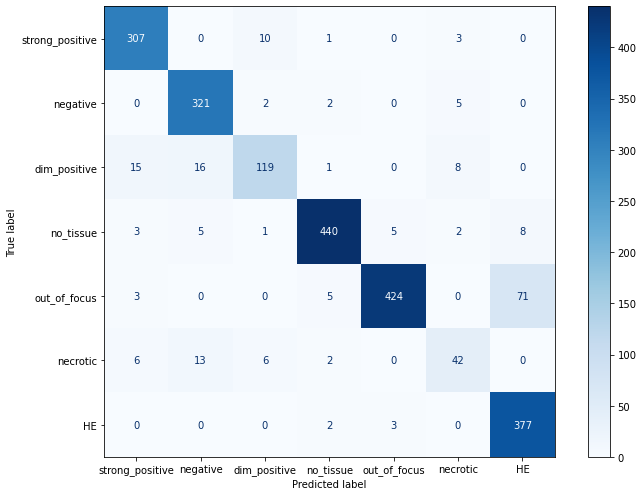

In [159]:
disp_confusion_matrix(test_results, label_counts)

## Setting Thresholds for every class

## Calculating accuarcy metrics 

In [163]:
softmax_acc_count = get_acc_count_max(test_results)

In [164]:
softmax_acc_count 

{'out_of_focus': {'tp': 424, 'fp': 79, 'total': 503},
 'strong_positive': {'tp': 307, 'fp': 14, 'total': 321},
 'negative': {'tp': 321, 'fp': 9, 'total': 330},
 'dim_positive': {'tp': 119, 'fp': 40, 'total': 159},
 'no_tissue': {'tp': 440, 'fp': 24, 'total': 464},
 'necrotic': {'tp': 42, 'fp': 27, 'total': 69},
 'HE': {'tp': 377, 'fp': 5, 'total': 382}}

In [165]:
for key in softmax_acc_count:
    print("'{}'".format(key))
    acc = softmax_acc_count[key]["tp"]*100/softmax_acc_count[key]["total"]
    precision = softmax_acc_count[key]["tp"]*100/(softmax_acc_count[key]["tp"] + softmax_acc_count[key]["fp"])
    print("Total samples: {}".format(softmax_acc_count[key]["total"]))
    print("True positives: {}".format(softmax_acc_count[key]["tp"]))
    print("False positives: {}".format(softmax_acc_count[key]["fp"]))
    print("Accuracy for '{}' is {}".format(key, acc))
    #print("Precision for '{}' is {}".format(key, precision))

    print()

'out_of_focus'
Total samples: 503
True positives: 424
False positives: 79
Accuracy for 'out_of_focus' is 84.29423459244533

'strong_positive'
Total samples: 321
True positives: 307
False positives: 14
Accuracy for 'strong_positive' is 95.6386292834891

'negative'
Total samples: 330
True positives: 321
False positives: 9
Accuracy for 'negative' is 97.27272727272727

'dim_positive'
Total samples: 159
True positives: 119
False positives: 40
Accuracy for 'dim_positive' is 74.84276729559748

'no_tissue'
Total samples: 464
True positives: 440
False positives: 24
Accuracy for 'no_tissue' is 94.82758620689656

'necrotic'
Total samples: 69
True positives: 42
False positives: 27
Accuracy for 'necrotic' is 60.869565217391305

'HE'
Total samples: 382
True positives: 377
False positives: 5
Accuracy for 'HE' is 98.69109947643979



In [166]:
df = pd.read_csv("/home/jupyter/model_preds/preds/edge_v1_1234_preds.csv")
df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,0.017182,0.017182,0.017182,0.905943,0.017182,0.012665,0.012665
1,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,0.011668,0.015830,0.011668,0.834650,0.098686,0.011668,0.015830
2,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,negative,0.011317,0.809528,0.129851,0.011317,0.011317,0.011317,0.015353
3,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,0.012780,0.017338,0.012780,0.012780,0.914202,0.012780,0.017338
4,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,HE,0.011572,0.015699,0.015699,0.015699,0.097872,0.015699,0.827760
...,...,...,...,...,...,...,...,...,...,...
2223,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,HE,0.015634,0.015634,0.015634,0.015634,0.097469,0.015634,0.824358
2224,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,strong_positive,0.887058,0.016824,0.022824,0.022824,0.016824,0.016824,0.016824
2225,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,negative,0.016735,0.882387,0.030800,0.022703,0.012336,0.022703,0.012336
2226,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,0.012654,0.012654,0.012654,0.905137,0.012654,0.012654,0.031594


In [167]:
test_results = df

In [169]:
test_results

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
0,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,0.017182,0.017182,0.017182,0.905943,0.017182,0.012665,0.012665,no_tissue
1,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,0.011668,0.015830,0.011668,0.834650,0.098686,0.011668,0.015830,no_tissue
2,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,negative,0.011317,0.809528,0.129851,0.011317,0.011317,0.011317,0.015353,negative
3,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus,0.012780,0.017338,0.012780,0.012780,0.914202,0.012780,0.017338,out_of_focus
4,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,HE,0.011572,0.015699,0.015699,0.015699,0.097872,0.015699,0.827760,HE
...,...,...,...,...,...,...,...,...,...,...,...
2223,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,HE,0.015634,0.015634,0.015634,0.015634,0.097469,0.015634,0.824358,HE
2224,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,strong_positive,0.887058,0.016824,0.022824,0.022824,0.016824,0.016824,0.016824,strong_positive
2225,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,negative,0.016735,0.882387,0.030800,0.022703,0.012336,0.022703,0.012336,negative
2226,TEST,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue,0.012654,0.012654,0.012654,0.905137,0.012654,0.012654,0.031594,no_tissue


In [170]:
label_counts = test_results['gt_label'].value_counts()
label_counts = pd.DataFrame(data=label_counts).rename(columns={"gt_label":"gt_label_count"})

In [171]:
label_counts

,gt_label_count
out_of_focus,503
no_tissue,464
HE,382
negative,330
strong_positive,321
dim_positive,159
necrotic,69


In [172]:
test_results['preds'].value_counts()

no_tissue          468
out_of_focus       441
HE                 438
negative           335
strong_positive    331
dim_positive       166
necrotic            49
Name: preds, dtype: int64

In [173]:
print(classification_report(test_results[['gt_label']], test_results[['preds']]))


                 precision    recall  f1-score   support

             HE       0.85      0.97      0.90       382
   dim_positive       0.80      0.83      0.81       159
       necrotic       0.73      0.52      0.61        69
       negative       0.93      0.95      0.94       330
      no_tissue       0.96      0.97      0.96       464
   out_of_focus       0.99      0.86      0.92       503
strong_positive       0.93      0.96      0.94       321

       accuracy                           0.92      2228
      macro avg       0.88      0.87      0.87      2228
   weighted avg       0.92      0.92      0.92      2228



                 gt_label_count
out_of_focus                503
no_tissue                   464
HE                          382
negative                    330
strong_positive             321
dim_positive                159
necrotic                     69


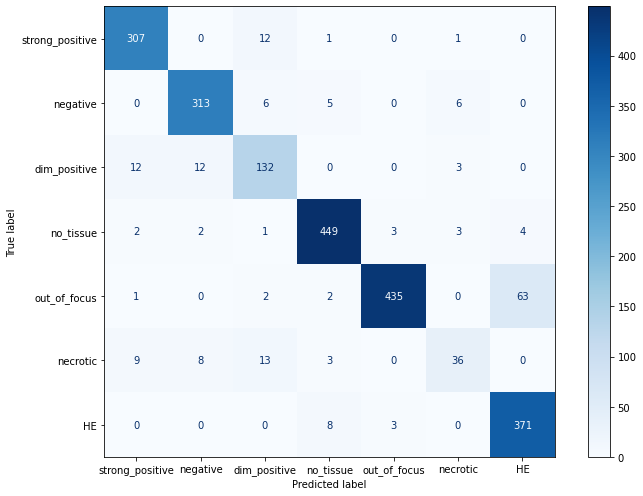

In [175]:
disp_confusion_matrix(test_results, label_counts)

## Setting Thresholds for every class

## Calculating accuarcy metrics 

In [179]:
softmax_acc_count = get_acc_count_max(test_results)

In [180]:
softmax_acc_count 

{'out_of_focus': {'tp': 435, 'fp': 68, 'total': 503},
 'strong_positive': {'tp': 307, 'fp': 14, 'total': 321},
 'negative': {'tp': 313, 'fp': 17, 'total': 330},
 'dim_positive': {'tp': 132, 'fp': 27, 'total': 159},
 'no_tissue': {'tp': 449, 'fp': 15, 'total': 464},
 'necrotic': {'tp': 36, 'fp': 33, 'total': 69},
 'HE': {'tp': 371, 'fp': 11, 'total': 382}}

In [181]:
for key in softmax_acc_count:
    print("'{}'".format(key))
    acc = softmax_acc_count[key]["tp"]*100/softmax_acc_count[key]["total"]
    precision = softmax_acc_count[key]["tp"]*100/(softmax_acc_count[key]["tp"] + softmax_acc_count[key]["fp"])
    print("Total samples: {}".format(softmax_acc_count[key]["total"]))
    print("True positives: {}".format(softmax_acc_count[key]["tp"]))
    print("False positives: {}".format(softmax_acc_count[key]["fp"]))
    print("Accuracy for '{}' is {}".format(key, acc))
    #print("Precision for '{}' is {}".format(key, precision))

    print()

'out_of_focus'
Total samples: 503
True positives: 435
False positives: 68
Accuracy for 'out_of_focus' is 86.48111332007953

'strong_positive'
Total samples: 321
True positives: 307
False positives: 14
Accuracy for 'strong_positive' is 95.6386292834891

'negative'
Total samples: 330
True positives: 313
False positives: 17
Accuracy for 'negative' is 94.84848484848484

'dim_positive'
Total samples: 159
True positives: 132
False positives: 27
Accuracy for 'dim_positive' is 83.01886792452831

'no_tissue'
Total samples: 464
True positives: 449
False positives: 15
Accuracy for 'no_tissue' is 96.76724137931035

'necrotic'
Total samples: 69
True positives: 36
False positives: 33
Accuracy for 'necrotic' is 52.17391304347826

'HE'
Total samples: 382
True positives: 371
False positives: 11
Accuracy for 'HE' is 97.12041884816755



# for model trained on subsets 1_1 and 1_2 and 1_3 combined
## Tested on test set

In [ ]:
#csv file path to tiles data in subset
csv_path1 = "/home/jupyter/subset_1_3/export_data-subset_1_2_3_combined-2021-01-14T05:58:28.968890Z/image_classification_1.csv"
df1 = pd.read_csv(csv_path1, header=None)
csv_path2 = "/home/jupyter/subset_1_3/export_data-subset_1_2_3_combined-2021-01-14T05:58:28.968890Z/image_classification_2.csv"
df2 = pd.read_csv(csv_path2, header=None)
df = pd.concat([df1, df2], ignore_index=True)
print(df[2].value_counts())
df.rename(columns={0:"split", 1:"path", 2:"gt_label"}, inplace=True)
df['strong_positive'] = 0.0 
df['negative']= 0.0
df['dim_positive'] = 0.0
df['no_tissue'] = 0.0
df['out_of_focus'] = 0.0
df['necrotic'] = 0.0
df['HE'] = 0.0
df

In [4]:
test_results=df[df['split']=='TEST']

In [5]:
df = test_results

In [6]:
BATCH_SIZE = 32
df_test = df[df["split"] == 'TEST']
equal_parts = int(df_test.shape[0]/BATCH_SIZE) + 1
df_arr = np.array_split(df, equal_parts)
len(df_arr)

53

In [7]:
df_arr[0].shape

(32, 10)

In [8]:
import os
os.path.exists('/home/jupyter/subset_1_1/export_data-seagen_subset_1_1-2020-12-23T08:55:47.943745Z/files/12574b2e-5a89-4a2d-a2e7-deec0a12707a.png')

False

In [36]:
df = get_preds(df_arr, df)

100%|██████████| 53/53 [02:37<00:00,  2.97s/it]


In [37]:
#df.to_csv("/home/jupyter/subsets_1_2_combined/preds/edge_v1_123_preds.csv", index=False)

In [10]:
df = pd.read_csv("/home/jupyter/subsets_1_2_combined/preds/edge_v1_123_preds.csv")
df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,no_tissue,0.018036,0.018036,0.013898,0.900059,0.018036,0.013898,0.018036
1,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,no_tissue,0.013572,0.013572,0.013572,0.677293,0.238750,0.013572,0.029667
2,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,negative,0.011862,0.768250,0.160788,0.015395,0.011862,0.011862,0.019980
3,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,out_of_focus,0.014177,0.014177,0.014177,0.010924,0.918189,0.014177,0.014177
4,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,HE,0.015868,0.020594,0.015868,0.015868,0.127702,0.012227,0.791873
...,...,...,...,...,...,...,...,...,...,...
1666,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,HE,0.015466,0.015466,0.011917,0.011917,0.161528,0.011917,0.771789
1667,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,strong_positive,0.944298,0.011235,0.011235,0.006670,0.008657,0.006670,0.011235
1668,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,negative,0.013607,0.881212,0.038599,0.017659,0.013607,0.017659,0.017659
1669,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,no_tissue,0.016566,0.016566,0.016566,0.826682,0.027902,0.016566,0.079152


In [11]:
test_results = df

In [12]:
test_results['preds'] = test_results[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']].idxmax(axis=1)

In [13]:
test_results

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
0,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,no_tissue,0.018036,0.018036,0.013898,0.900059,0.018036,0.013898,0.018036,no_tissue
1,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,no_tissue,0.013572,0.013572,0.013572,0.677293,0.238750,0.013572,0.029667,no_tissue
2,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,negative,0.011862,0.768250,0.160788,0.015395,0.011862,0.011862,0.019980,negative
3,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,out_of_focus,0.014177,0.014177,0.014177,0.010924,0.918189,0.014177,0.014177,out_of_focus
4,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,HE,0.015868,0.020594,0.015868,0.015868,0.127702,0.012227,0.791873,HE
...,...,...,...,...,...,...,...,...,...,...,...
1666,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,HE,0.015466,0.015466,0.011917,0.011917,0.161528,0.011917,0.771789,HE
1667,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,strong_positive,0.944298,0.011235,0.011235,0.006670,0.008657,0.006670,0.011235,strong_positive
1668,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,negative,0.013607,0.881212,0.038599,0.017659,0.013607,0.017659,0.017659,negative
1669,TEST,gs://seagen-quantiphi/subset_1_3/export_data-s...,no_tissue,0.016566,0.016566,0.016566,0.826682,0.027902,0.016566,0.079152,no_tissue


In [14]:
label_counts = test_results['gt_label'].value_counts()
label_counts = pd.DataFrame(data=label_counts).rename(columns={"gt_label":"gt_label_count"})

In [15]:
label_counts

,gt_label_count
out_of_focus,389
no_tissue,347
negative,263
HE,260
strong_positive,237
dim_positive,126
necrotic,49


In [16]:
test_results['preds'].value_counts()

out_of_focus       334
no_tissue          334
HE                 318
negative           274
strong_positive    246
dim_positive       128
necrotic            37
Name: preds, dtype: int64

In [34]:
print(classification_report(test_results[['gt_label']], test_results[['preds']]))


                 precision    recall  f1-score   support

             HE       0.80      0.98      0.88       260
   dim_positive       0.79      0.80      0.80       126
       necrotic       0.81      0.61      0.70        49
       negative       0.93      0.97      0.95       263
      no_tissue       0.99      0.95      0.97       347
   out_of_focus       0.98      0.84      0.91       389
strong_positive       0.93      0.96      0.94       237

       accuracy                           0.91      1671
      macro avg       0.89      0.87      0.88      1671
   weighted avg       0.92      0.91      0.91      1671



                 gt_label_count
out_of_focus                389
no_tissue                   347
negative                    263
HE                          260
strong_positive             237
dim_positive                126
necrotic                     49


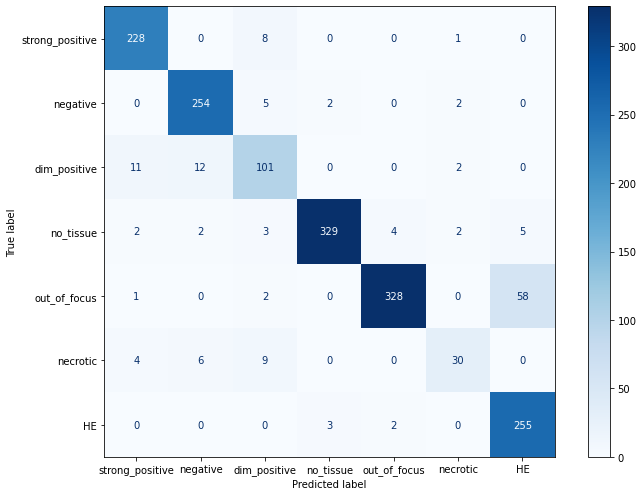

In [19]:
disp_confusion_matrix(test_results, label_counts)

## Setting Thresholds for every class

## Calculating accuarcy metrics 

In [63]:
acc_count

{'out_of_focus': {'tp': 326, 'fp': 6, 'total': 389},
 'strong_positive': {'tp': 225, 'fp': 11, 'total': 237},
 'negative': {'tp': 250, 'fp': 15, 'total': 263},
 'dim_positive': {'tp': 97, 'fp': 21, 'total': 126},
 'no_tissue': {'tp': 322, 'fp': 2, 'total': 347},
 'necrotic': {'tp': 25, 'fp': 4, 'total': 49},
 'HE': {'tp': 254, 'fp': 62, 'total': 260}}

In [23]:
softmax_acc_count = get_acc_count_max(test_results)

In [24]:
softmax_acc_count 

{'out_of_focus': {'tp': 328, 'fp': 61, 'total': 389},
 'strong_positive': {'tp': 228, 'fp': 9, 'total': 237},
 'negative': {'tp': 254, 'fp': 9, 'total': 263},
 'dim_positive': {'tp': 101, 'fp': 25, 'total': 126},
 'no_tissue': {'tp': 329, 'fp': 18, 'total': 347},
 'necrotic': {'tp': 30, 'fp': 19, 'total': 49},
 'HE': {'tp': 255, 'fp': 5, 'total': 260}}

In [28]:
for key in softmax_acc_count:
    print("'{}'".format(key))
    acc = softmax_acc_count[key]["tp"]*100/softmax_acc_count[key]["total"]
    precision = softmax_acc_count[key]["tp"]*100/(softmax_acc_count[key]["tp"] + softmax_acc_count[key]["fp"])
    print("Total samples: {}".format(softmax_acc_count[key]["total"]))
    print("True positives: {}".format(softmax_acc_count[key]["tp"]))
    print("False positives: {}".format(softmax_acc_count[key]["fp"]))
    print("Accuracy for '{}' is {}".format(key, acc))
    #print("Precision for '{}' is {}".format(key, precision))

    print()

'out_of_focus'
Total samples: 389
True positives: 328
False positives: 61
Accuracy for 'out_of_focus' is 84.31876606683805

'strong_positive'
Total samples: 237
True positives: 228
False positives: 9
Accuracy for 'strong_positive' is 96.20253164556962

'negative'
Total samples: 263
True positives: 254
False positives: 9
Accuracy for 'negative' is 96.57794676806084

'dim_positive'
Total samples: 126
True positives: 101
False positives: 25
Accuracy for 'dim_positive' is 80.15873015873017

'no_tissue'
Total samples: 347
True positives: 329
False positives: 18
Accuracy for 'no_tissue' is 94.81268011527378

'necrotic'
Total samples: 49
True positives: 30
False positives: 19
Accuracy for 'necrotic' is 61.224489795918366

'HE'
Total samples: 260
True positives: 255
False positives: 5
Accuracy for 'HE' is 98.07692307692308



# for model trained on subsets 1_1 and 1_2 combined
## Tested on test set

In [52]:
'''#csv file path to tiles data in subset
csv_path = "/home/jupyter/subset_1_1/test/export_data-subsets_1_2_combined-2021-01-11T19:18:36.276290Z/image_classification_1.csv"
df = pd.read_csv(csv_path, header=None)
df.rename(columns={0:"split", 1:"path", 2:"gt_label"}, inplace=True)
df['strong_positive'] = 0.0 
df['negative']= 0.0
df['dim_positive'] = 0.0
df['no_tissue'] = 0.0
df['out_of_focus'] = 0.0
df['necrotic'] = 0.0
df['HE'] = 0.0
df.head()'''

#csv file path to tiles data in subset
csv_path1 = "/home/jupyter/subset_1_1/test/export_data-subsets_1_2_combined-2021-01-11T19:18:36.276290Z/image_classification_1.csv"
df1 = pd.read_csv(csv_path1, header=None)
csv_path2 = "/home/jupyter/subset_1_1/test/export_data-subsets_1_2_combined-2021-01-11T19:18:36.276290Z/image_classification_2.csv"
df2 = pd.read_csv(csv_path2, header=None)
df = pd.concat([df1, df2], ignore_index=True)
print(df[2].value_counts())
df.rename(columns={0:"split", 1:"path", 2:"gt_label"}, inplace=True)
df['strong_positive'] = 0.0 
df['negative']= 0.0
df['dim_positive'] = 0.0
df['no_tissue'] = 0.0
df['out_of_focus'] = 0.0
df['necrotic'] = 0.0
df['HE'] = 0.0
df

out_of_focus       2767
no_tissue          2348
HE                 1683
negative           1584
strong_positive    1467
dim_positive        933
necrotic            352
Name: 2, dtype: int64


,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TRAIN,gs://seagen-quantiphi/subset_1_1/test/export_d...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRAIN,gs://seagen-quantiphi/subset_1_1/test/export_d...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRAIN,gs://seagen-quantiphi/subset_1_1/test/export_d...,dim_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRAIN,gs://seagen-quantiphi/subset_1_1/test/export_d...,dim_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRAIN,gs://seagen-quantiphi/subset_1_1/test/export_d...,HE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11129,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,no_tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11130,TRAIN,gs://seagen-quantiphi/subset_1_1/test/export_d...,HE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11131,TRAIN,gs://seagen-quantiphi/subset_1_1/test/export_d...,negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11132,TRAIN,gs://seagen-quantiphi/subset_1_1/test/export_d...,strong_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
test_results=df[df['split']=='TEST']

In [54]:
df = test_results

In [55]:
BATCH_SIZE = 32
df_test = df[df["split"] == 'TEST']
equal_parts = int(df_test.shape[0]/BATCH_SIZE) + 1
df_arr = np.array_split(df, equal_parts)
len(df_arr)

35

In [56]:
df_arr[0].shape

(32, 10)

In [57]:
df = get_preds(df_arr, df)

100%|██████████| 35/35 [02:07<00:00,  3.64s/it]


In [58]:
df.to_csv("/home/jupyter/subsets_1_2_combined/preds/edge_v1_preds.csv", index=False)

In [59]:
df = pd.read_csv("/home/jupyter/subsets_1_2_combined/preds/edge_v1_preds.csv")
df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,no_tissue,0.016048,0.016048,0.016048,0.705718,0.199939,0.016048,0.030150
1,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,negative,0.019983,0.878754,0.037543,0.019983,0.014579,0.014579,0.014579
2,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,out_of_focus,0.015066,0.015066,0.015066,0.015066,0.908095,0.010992,0.020650
3,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,out_of_focus,0.023215,0.016937,0.012356,0.031820,0.153945,0.016937,0.744791
4,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,negative,0.014951,0.901197,0.028090,0.014951,0.014951,0.010908,0.014951
...,...,...,...,...,...,...,...,...,...,...
1109,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,strong_positive,0.938018,0.011354,0.008283,0.011354,0.011354,0.008283,0.011354
1110,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,negative,0.011191,0.924559,0.015339,0.011191,0.011191,0.011191,0.015339
1111,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,strong_positive,0.935147,0.011319,0.008258,0.011319,0.011319,0.011319,0.011319
1112,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,HE,0.012803,0.012803,0.012803,0.017549,0.159512,0.012803,0.771725


In [60]:
test_results=df[df['split']=='TEST']

In [61]:
test_results

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,no_tissue,0.016048,0.016048,0.016048,0.705718,0.199939,0.016048,0.030150
1,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,negative,0.019983,0.878754,0.037543,0.019983,0.014579,0.014579,0.014579
2,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,out_of_focus,0.015066,0.015066,0.015066,0.015066,0.908095,0.010992,0.020650
3,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,out_of_focus,0.023215,0.016937,0.012356,0.031820,0.153945,0.016937,0.744791
4,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,negative,0.014951,0.901197,0.028090,0.014951,0.014951,0.010908,0.014951
...,...,...,...,...,...,...,...,...,...,...
1109,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,strong_positive,0.938018,0.011354,0.008283,0.011354,0.011354,0.008283,0.011354
1110,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,negative,0.011191,0.924559,0.015339,0.011191,0.011191,0.011191,0.015339
1111,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,strong_positive,0.935147,0.011319,0.008258,0.011319,0.011319,0.011319,0.011319
1112,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,HE,0.012803,0.012803,0.012803,0.017549,0.159512,0.012803,0.771725


In [62]:
#test_results = df

In [63]:
test_results['preds'] = test_results[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']].idxmax(axis=1)

In [64]:
test_results

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
0,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,no_tissue,0.016048,0.016048,0.016048,0.705718,0.199939,0.016048,0.030150,no_tissue
1,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,negative,0.019983,0.878754,0.037543,0.019983,0.014579,0.014579,0.014579,negative
2,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,out_of_focus,0.015066,0.015066,0.015066,0.015066,0.908095,0.010992,0.020650,out_of_focus
3,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,out_of_focus,0.023215,0.016937,0.012356,0.031820,0.153945,0.016937,0.744791,HE
4,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,negative,0.014951,0.901197,0.028090,0.014951,0.014951,0.010908,0.014951,negative
...,...,...,...,...,...,...,...,...,...,...,...
1109,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,strong_positive,0.938018,0.011354,0.008283,0.011354,0.011354,0.008283,0.011354,strong_positive
1110,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,negative,0.011191,0.924559,0.015339,0.011191,0.011191,0.011191,0.015339,negative
1111,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,strong_positive,0.935147,0.011319,0.008258,0.011319,0.011319,0.011319,0.011319,strong_positive
1112,TEST,gs://seagen-quantiphi/subset_1_1/test/export_d...,HE,0.012803,0.012803,0.012803,0.017549,0.159512,0.012803,0.771725,HE


In [65]:
label_counts = test_results['gt_label'].value_counts()
label_counts = pd.DataFrame(data=label_counts).rename(columns={"gt_label":"gt_label_count"})

In [66]:
label_counts

,gt_label_count
out_of_focus,273
no_tissue,236
negative,180
HE,156
strong_positive,152
dim_positive,85
necrotic,32


In [67]:
test_results['preds'].value_counts()

no_tissue          233
out_of_focus       229
HE                 199
negative           174
strong_positive    159
dim_positive        84
necrotic            36
Name: preds, dtype: int64

In [68]:
print(classification_report(test_results[['gt_label']], test_results[['preds']]))


                 precision    recall  f1-score   support

             HE       0.76      0.97      0.85       156
   dim_positive       0.85      0.84      0.84        85
       necrotic       0.58      0.66      0.62        32
       negative       0.94      0.91      0.93       180
      no_tissue       0.98      0.97      0.97       236
   out_of_focus       0.99      0.83      0.90       273
strong_positive       0.92      0.97      0.95       152

       accuracy                           0.90      1114
      macro avg       0.86      0.88      0.86      1114
   weighted avg       0.92      0.90      0.91      1114



                 gt_label_count
out_of_focus                273
no_tissue                   236
negative                    180
HE                          156
strong_positive             152
dim_positive                 85
necrotic                     32


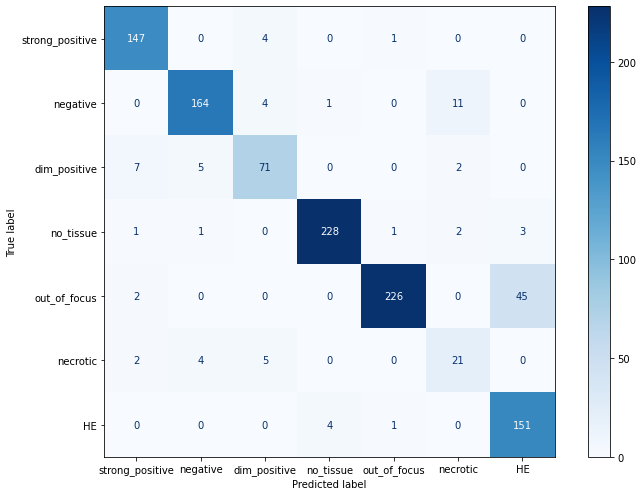

In [69]:
disp_confusion_matrix(test_results, label_counts)

## Setting Thresholds for every class

## Calculating accuarcy metrics 

In [70]:
softmax_acc_count = get_acc_count_max(test_results)

In [71]:
softmax_acc_count

{'out_of_focus': {'tp': 226, 'fp': 47, 'total': 273},
 'strong_positive': {'tp': 147, 'fp': 5, 'total': 152},
 'negative': {'tp': 164, 'fp': 16, 'total': 180},
 'dim_positive': {'tp': 71, 'fp': 14, 'total': 85},
 'no_tissue': {'tp': 228, 'fp': 8, 'total': 236},
 'necrotic': {'tp': 21, 'fp': 11, 'total': 32},
 'HE': {'tp': 151, 'fp': 5, 'total': 156}}

In [72]:
for key in softmax_acc_count:
    print("'{}'".format(key))
    acc = softmax_acc_count[key]["tp"]*100/softmax_acc_count[key]["total"]
    precision = softmax_acc_count[key]["tp"]*100/(softmax_acc_count[key]["tp"] + softmax_acc_count[key]["fp"])
    print("Total samples: {}".format(softmax_acc_count[key]["total"]))
    print("True positives: {}".format(softmax_acc_count[key]["tp"]))
    print("False positives: {}".format(softmax_acc_count[key]["fp"]))
    print("Accuracy for '{}' is {}".format(key, acc))
    #print("Precision for '{}' is {}".format(key, precision))

    print()

'out_of_focus'
Total samples: 273
True positives: 226
False positives: 47
Accuracy for 'out_of_focus' is 82.78388278388279

'strong_positive'
Total samples: 152
True positives: 147
False positives: 5
Accuracy for 'strong_positive' is 96.71052631578948

'negative'
Total samples: 180
True positives: 164
False positives: 16
Accuracy for 'negative' is 91.11111111111111

'dim_positive'
Total samples: 85
True positives: 71
False positives: 14
Accuracy for 'dim_positive' is 83.52941176470588

'no_tissue'
Total samples: 236
True positives: 228
False positives: 8
Accuracy for 'no_tissue' is 96.61016949152543

'necrotic'
Total samples: 32
True positives: 21
False positives: 11
Accuracy for 'necrotic' is 65.625

'HE'
Total samples: 156
True positives: 151
False positives: 5
Accuracy for 'HE' is 96.7948717948718



# For model trained on subset_1_1 edge model 
## tested on subset_1_2

In [73]:
#csv file path to tiles data in subset
csv_path = "/home/jupyter/subset_1_2/export_data-seagen_subset_1_2-2021-01-08T08:10:51.904341Z/image_classification_1.csv"
df = pd.read_csv(csv_path, header=None)
df.rename(columns={0:"split", 1:"path", 2:"gt_label"}, inplace=True)
df['strong_positive'] = 0.0 
df['negative']= 0.0
df['dim_positive'] = 0.0
df['no_tissue'] = 0.0
df['out_of_focus'] = 0.0
df['necrotic'] = 0.0
df['HE'] = 0.0

df.head()

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,dim_positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,out_of_focus,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
BATCH_SIZE = 32
df_test = df[df["split"] == 'TRAIN']
equal_parts = int(df_test.shape[0]/BATCH_SIZE) + 1
df_arr = np.array_split(df, equal_parts)
len(df_arr)

140

In [75]:
df["path"][1][22:]

'subset_1_2/export_data-seagen_subset_1_2-2021-01-08T08:10:51.904341Z/files/e340b148-1c8c-4c61-ac18-d8c094527949.png'

In [76]:
os.path.exists(img_path)

True

In [77]:
df_arr[0].shape

(40, 10)

In [78]:
for ds in tqdm(df_arr):
    instances = {
            'instances': []}
    for indx in ds.index:
        img_path = "/home/jupyter/" + df["path"][indx][22:]
        image_key = df["path"][indx]
        with io.open(img_path, 'rb') as image_file:
            encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
        example = {
            'image_bytes': {'b64': str(encoded_image)},
            'key': image_key
        }
        instances['instances'].append(example)
    
    url = 'http://192.168.2.4:{}/v1/models/default:predict'.format(8501)
    response = requests.post(url, data=json.dumps(instances))
    res = response.json()
    for pred in res["predictions"]:
        key = pred['key']
        for i,label in enumerate(pred['labels']):
            ds.loc[df.path == key, label] = pred['scores'][i]
            
df = pd.concat(df_arr)


100%|██████████| 140/140 [11:08<00:00,  4.78s/it]


In [79]:
#df.to_csv("/home/jupyter/subset_1_2/preds/edge_v1_preds.csv", index=False)

In [90]:
df = pd.read_csv("/home/jupyter/subset_1_2/preds/edge_v1_preds.csv")
df

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE
0,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,out_of_focus,0.016948,0.003286,0.003814,0.001343,0.019674,0.004428,0.950508
1,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,dim_positive,0.107890,0.001059,0.870534,0.001059,0.002592,0.003493,0.013371
2,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,negative,0.002921,0.980978,0.002516,0.001194,0.005305,0.004570,0.002516
3,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,out_of_focus,0.004567,0.003934,0.003389,0.001866,0.980341,0.003389,0.002515
4,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,negative,0.002900,0.973951,0.003367,0.001376,0.002152,0.012887,0.003367
...,...,...,...,...,...,...,...,...,...,...
5562,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,HE,0.021011,0.015592,0.015592,0.018100,0.265193,0.015592,0.648921
5563,TEST,gs://seagen-quantiphi/subset_1_2/export_data-s...,no_tissue,0.020731,0.006287,0.009835,0.862799,0.020731,0.020731,0.058887
5564,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,HE,0.004507,0.004507,0.002881,0.001587,0.009500,0.009500,0.967518
5565,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,negative,0.004563,0.979658,0.003386,0.001384,0.003931,0.004563,0.002513


In [91]:
#test_results=df[df['split']=='TEST']

In [92]:
#test_results

In [93]:
test_results = df

In [94]:
test_results['preds'] = test_results[['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']].idxmax(axis=1)

In [95]:
test_results

,split,path,gt_label,strong_positive,negative,dim_positive,no_tissue,out_of_focus,necrotic,HE,preds
0,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,out_of_focus,0.016948,0.003286,0.003814,0.001343,0.019674,0.004428,0.950508,HE
1,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,dim_positive,0.107890,0.001059,0.870534,0.001059,0.002592,0.003493,0.013371,dim_positive
2,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,negative,0.002921,0.980978,0.002516,0.001194,0.005305,0.004570,0.002516,negative
3,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,out_of_focus,0.004567,0.003934,0.003389,0.001866,0.980341,0.003389,0.002515,out_of_focus
4,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,negative,0.002900,0.973951,0.003367,0.001376,0.002152,0.012887,0.003367,negative
...,...,...,...,...,...,...,...,...,...,...,...
5562,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,HE,0.021011,0.015592,0.015592,0.018100,0.265193,0.015592,0.648921,HE
5563,TEST,gs://seagen-quantiphi/subset_1_2/export_data-s...,no_tissue,0.020731,0.006287,0.009835,0.862799,0.020731,0.020731,0.058887,no_tissue
5564,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,HE,0.004507,0.004507,0.002881,0.001587,0.009500,0.009500,0.967518,HE
5565,TRAIN,gs://seagen-quantiphi/subset_1_2/export_data-s...,negative,0.004563,0.979658,0.003386,0.001384,0.003931,0.004563,0.002513,negative


In [96]:
label_counts = test_results['gt_label'].value_counts()
label_counts = pd.DataFrame(data=label_counts).rename(columns={"gt_label":"gt_label_count"})

In [97]:
label_counts

,gt_label_count
out_of_focus,1306
no_tissue,1201
HE,902
negative,815
strong_positive,732
dim_positive,491
necrotic,120


In [98]:
test_results['preds'].value_counts()

out_of_focus       1175
no_tissue          1169
HE                 1025
strong_positive     797
negative            767
dim_positive        414
necrotic            220
Name: preds, dtype: int64

In [99]:
print(classification_report(test_results[['gt_label']], test_results[['preds']]))


                 precision    recall  f1-score   support

             HE       0.85      0.97      0.91       902
   dim_positive       0.78      0.66      0.71       491
       necrotic       0.38      0.69      0.49       120
       negative       0.93      0.87      0.90       815
      no_tissue       0.95      0.93      0.94      1201
   out_of_focus       0.97      0.88      0.92      1306
strong_positive       0.88      0.95      0.91       732

       accuracy                           0.89      5567
      macro avg       0.82      0.85      0.83      5567
   weighted avg       0.90      0.89      0.89      5567



                 gt_label_count
out_of_focus               1306
no_tissue                  1201
HE                          902
negative                    815
strong_positive             732
dim_positive                491
necrotic                    120


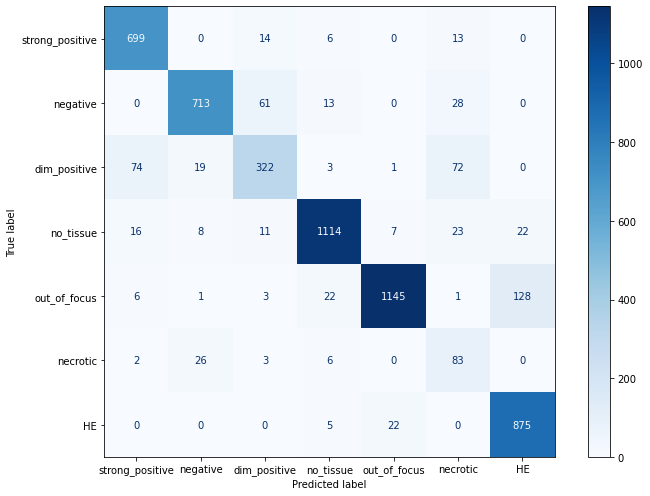

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true=test_results['gt_label'],y_pred = test_results['preds'], labels = ['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE'])
display_labels = ['strong_positive','negative','dim_positive','no_tissue','out_of_focus', 'necrotic', 'HE']
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
print(label_counts)
plt.rcParams["figure.figsize"] = (10,7)
disp = disp.plot(cmap = plt.cm.Blues)
plt.tight_layout()
plt.show()


## Setting Thresholds for every class

In [101]:
oof_df = test_results[test_results['gt_label'] == 'out_of_focus']
strong_pos_df = test_results[test_results['gt_label'] == 'strong_positive']
negative_df = test_results[test_results['gt_label'] == 'negative']
dim_pos_df = test_results[test_results['gt_label'] == 'dim_positive']
no_tissue_df = test_results[test_results['gt_label'] == 'no_tissue']
necrotic_df = test_results[test_results['gt_label'] == 'necrotic']
he_df = test_results[test_results['gt_label'] == 'HE']


In [102]:
def out_of_focus(out_of_focus_prob, thresh):
    if out_of_focus_prob > thresh:
        return True
    else:
        return False
    
def strong_positive(strong_positive_prob, thresh):
    if strong_positive_prob > thresh:
        return True
    else:
        return False
    
def negative(negative_prob, thresh):
    if negative_prob > thresh:
        return True
    else:
        return False
    
def dim_positive(dim_positive_prob, thresh):
    if dim_positive_prob > thresh:
        return True
    else:
        return False
    
def no_tissue(no_tissue_prob, thresh):
    if no_tissue_prob > thresh:
        return True
    else:
        return False
    
def necrotic(necrotic_prob, thresh):
    if necrotic_prob > thresh:
        return True
    else:
        return False
    
def he(he_prob, thresh):
    if he_prob > thresh:
        return True
    else:
        return False


## Calculating accuarcy metrics 

In [111]:
acc_count = {"out_of_focus": {"tp": 0, "fp": 0, "total": 0},
             "strong_positive": {"tp": 0, "fp": 0, "total": 0},
             "negative": {"tp": 0, "fp":0, "total": 0},
             "dim_positive": {"tp": 0, "fp":0, "total": 0},
             "no_tissue": {"tp": 0, "fp":0, "total": 0},
             "necrotic": {"tp": 0, "fp":0, "total": 0},
             "HE": {"tp": 0, "fp":0, "total": 0}}
df = test_results

#df.drop(columns=['preds'], inplace =True)
df["preds"] = ""
for indx in df.index:
    gt_label = df["gt_label"][indx]
    #if gt_label == "necrotic" or gt_label == "HE" or gt_label == "no_tissue" or gt_label == "dim_positive":
        #continue
    acc_count[gt_label]["total"] += 1
    out_of_focus_prob, strong_positive_prob, negative_prob, dim_positive_prob, no_tissue_prob, necrotic_prob, he_prob = df["out_of_focus"][indx], df["strong_positive"][indx], df["negative"][indx], df["dim_positive"][indx], df["no_tissue"][indx], df["necrotic"][indx], df["HE"][indx]
    
        
    # OOF
    if out_of_focus(out_of_focus_prob, 0.9):
        if gt_label == "out_of_focus":
            acc_count[gt_label]["tp"] += 1
        else:
            #print(df["path"][indx])
            acc_count["out_of_focus"]["fp"] += 1
        df["preds"][indx] = "out_of_focus"
        continue
        
    # Strong Positive
    if strong_positive(strong_positive_prob,0.9):
        if gt_label == "strong_positive":
            acc_count[gt_label]["tp"] += 1
        else:
            acc_count["strong_positive"]["fp"] += 1
            #print(df["gt_label"][indx], brown_cover)
        df["preds"][indx] = "strong_positive"
        continue
        
    # Negative
    if negative(negative_prob, 0.9):
        if gt_label == "negative":
            acc_count[gt_label]["tp"] += 1
        else:
            acc_count["negative"]["fp"] += 1
        df["preds"][indx] = "negative"
        continue
    
    # dim_positive
    if dim_positive(dim_positive_prob,0.9):
        if gt_label == "dim_positive":
            acc_count[gt_label]["tp"] += 1
        else:
            acc_count["dim_positive"]["fp"] += 1
        df["preds"][indx] = "dim_positive"
        continue
    
        
    # necrotic
    if necrotic(necrotic_prob,0.8):
        if gt_label == "necrotic":
            acc_count[gt_label]["tp"] += 1
        else:
            acc_count["necrotic"]["fp"] += 1
        df["preds"][indx] = "necrotic"
        continue
      
    # HE
    if he(he_prob, 0.9):
        if gt_label == "HE":
            acc_count[gt_label]["tp"] += 1
        else:
            acc_count["HE"]["fp"] += 1
        df["preds"][indx] = "HE"
        continue
    
    if no_tissue(no_tissue_prob, 0.9):
        if gt_label == "no_tissue":
            acc_count[gt_label]["tp"] += 1
        else:
            acc_count["no_tissue"]["fp"] += 1
        df["preds"][indx] = "no_tissue"
        continue
         
    
        
    
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to b

In [112]:
acc_count

{'out_of_focus': {'tp': 1054, 'fp': 3, 'total': 1306},
 'strong_positive': {'tp': 629, 'fp': 33, 'total': 732},
 'negative': {'tp': 582, 'fp': 14, 'total': 815},
 'dim_positive': {'tp': 197, 'fp': 19, 'total': 491},
 'no_tissue': {'tp': 747, 'fp': 2, 'total': 1201},
 'necrotic': {'tp': 51, 'fp': 57, 'total': 120},
 'HE': {'tp': 384, 'fp': 22, 'total': 902}}

In [113]:
for key in acc_count:
    print("'{}'".format(key))
    acc = acc_count[key]["tp"]*100/acc_count[key]["total"]
    precision = acc_count[key]["tp"]*100/(acc_count[key]["tp"] + acc_count[key]["fp"])
    print("Total samples: {}".format(acc_count[key]["total"]))
    print("True positives: {}".format(acc_count[key]["tp"]))
    print("False positives: {}".format(acc_count[key]["fp"]))
    print("Accuracy for '{}' is {}".format(key, acc))
    print("Precision for '{}' is {}".format(key, precision))

    print()

'out_of_focus'
Total samples: 1306
True positives: 1054
False positives: 3
Accuracy for 'out_of_focus' is 80.70444104134762
Precision for 'out_of_focus' is 99.71617786187322

'strong_positive'
Total samples: 732
True positives: 629
False positives: 33
Accuracy for 'strong_positive' is 85.92896174863388
Precision for 'strong_positive' is 95.01510574018127

'negative'
Total samples: 815
True positives: 582
False positives: 14
Accuracy for 'negative' is 71.41104294478528
Precision for 'negative' is 97.6510067114094

'dim_positive'
Total samples: 491
True positives: 197
False positives: 19
Accuracy for 'dim_positive' is 40.122199592668025
Precision for 'dim_positive' is 91.20370370370371

'no_tissue'
Total samples: 1201
True positives: 747
False positives: 2
Accuracy for 'no_tissue' is 62.19816819317236
Precision for 'no_tissue' is 99.73297730307075

'necrotic'
Total samples: 120
True positives: 51
False positives: 57
Accuracy for 'necrotic' is 42.5
Precision for 'necrotic' is 47.222222222